In [1]:
%matplotlib notebook

In [2]:
import pymc as pm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

### 2.1 PyMC规则与设计模式

#### 一. 父变量与子变量
1. 父变量 : 对其他变量有影响的变量  
 子变量 : 被其他变量影响的变量, 父变量作用于子变量  
2. 一个变量可以即是父变量, 又是子变量
3. 如下代码所示  
  变量_lambda控制着变量_data, 因此_lambda是_data的父变量
 ```python
 import pymc as pm
_lambda = pm.Exponential('lambda',1)
_data = pm.Poisson('data',_lambda)
_data_plus_one = _data + 1
 ```
4. 通过变量的children和parents属性获取变量的父/子变量  
 如下代码发现parents获得_data的父变量的内存地址与_lambda相同  
 ```python
print hex(id(_lambda))  # 0x1a13752990
print _data.parents       # {'mu': <pymc.distributions.Exponential 'lambda' at 0x1a13752990>}
 ```
 
#### 二. PyMC变量
1. PyMC对象, 都使用`value`属性获取当前时刻, 对象内存储的值(返回1个元素的ndarray)   
```python
print _lambda.value  # ndarray(0.9853300186895546)
```
2. **PyMC变量类型**  
  1. 随机型变量   
    对象内部用于计算的值会变化. 即调用一次对象的random()方法后, 对象的value属性获取值更改  
  2. 确定型变量  
    指如果变量的父变量确定, 则他的值不再随机. 一种快速检测方法 : 如果知道了所有foo的父变量值, 则可以判断foo的取值是多少

3.  **PyMC初始化随机变量**   
 初始化一个随机变量时, 第一个参数是string, 表示变量名. 后面的参数表示该随机变量服从的概率分布中的参数值. 不同概率分布需要传入的参数不同
 ```python
some_value = pm.DiscreteUniform('discrete_uni_var',0,10) # 离散均匀分布: [0,10]
```
4. **多变量初始化**  
 多个同分布的变量, 与其初始化多次单个变量再组成数组, 不如一次打包初始化.  
 打包初始化的多变量, 返回是'数组形式'的PyMC变量. 该数组可以当做numpy的数组使用. 对该数组调用value属性同样返回一个numpy数组
 ```python
# 多变量分别初始化
beta_1 = pm.DiscreteUniform('betas',0,10)
beta_2 = pm.DiscreteUniform('betas',0,10)
# 多变量打包初始化
betas = pm.DiscreteUniform('betas',0,10,size=2)
betas.value  # array([8, 5])
```

5. **随机变量调用random()**  
  调用PyMC随机变量的random()方法, 会产生一个新的随机值
 ```python
_lambda = pm.Exponential('lambda',1)
print _lambda.value  # 0.06077825538858841
_lambda.random()
print _lambda.value  # 0.7676321346809103
```

6. **确定型变量**  
  1. 对PyMC对象的操作, 加减乘除运算, 指数和类似操作都会产生确定型变量  
  ```python
lambda_1 = pm.Exponential('lambda_1',1)
lambda_2 = pm.Exponential('lambda_2',1)
type(lambda_1+lambda_2)
# [out]: pymc.PyMCObjects.Deterministic
```
  1. PyMC常用于模拟一个随机变量. 因此为了区分, 确定型变量使用`pymc.deterministic`标记封装一个确定型变量 (一个函数装饰器)  
    1. 确定型变量不能调用random()方法
    2. 确定型变量并非永远不变. 若其父变量是随机变量, 则每当父变量调用random()改变自身值后, 该确定型变量值也会发生变化  
       ```python 
        import numpy as np
        lambda_1 = pm.Exponential('lambda_1',1)
        lambda_2 = pm.Exponential('lambda_2',1)
        tau = pm.DiscreteUniform('tau',lower=0,upper=5)

        @pm.deterministic
        def some_deterministic_value(tau=tau,lambda_1=lambda_1,lambda_2=lambda_2):
            out = np.zeros(5)
            out[:tau] = lambda_1
            out[tau:] = lambda_2
            return out
        # 查看确定型变量内部的值
        print some_deterministic_value.value
        # 改变父变量的值
        print lambda_1.random()
        # 子变量的值也改变
        print some_deterministic_value.value

        # [0.44791845 0.44791845 0.44791845 1.64404658 1.64404658]
        # 0.1915637712762092
        # [0.19156377 0.19156377 0.19156377 1.64404658 1.64404658]
        ```
        
#### 三. 模型加入观测值
1. 模型中指定先验  
 以上随机变量声明的步骤, 表明我们确定了参数的先验分布. 例如, 我们可以提问并解答"先验分布$\lambda $是什么". 以下代码给出$\lambda $的分布图
 <img src='img/prioere1.png' width='90%' height='90%'>
2. 将证据, 观测值加入随机变量  
 PyMC随机变量有个额外的参数, observed:布尔变量, 用于固定随机变量的取值   
 加入观测值的随机变量, random方法不会改变value存储的值
 ```python
data = np.array([10,5])
fixed_variable = pm.Poisson('fxd',1,value=data,observed=True)
print fixed_variable.value
fixed_variable.random()
print fixed_variable.value
# out : [10  5]
#         [10  5]
```

### 2.2 PyMC建模方式

#### 一. 思考步骤 (用第一章, 对短信接收次数建模为例)
1. 什么随机变量可以描述这些'短信接收次数'数据  
 Poisson分布适合对count类型数据建模
2. 假设'短信接收次数'服从Poisson分布, 所以Poisson分布引入参数 $\lambda$
3. $\lambda$的参数值我们知道吗? 显然并不知道. 我们猜测$\lambda$ 有两个取值, 一个属于早期行为, 另一个属于后其行为.但是我们并不确切知道什么时候发生的变化. 所以这个转换点也要被建模  
  1. 两个$\lambda$ 来自什么样的分布呢? 因为泊松分布的参数$\lambda$ 大于0, 因此, 对于正实数给出概率的指数分布可用于对$\lambda$ 建模. 这个指数分布自身也有参数, 称他为$\lambda 2$, 为了便于表示, 我们让参数$\alpha$=$ \frac{1}{\lambda2}$.此时, 可以继续对$\alpha$建模, 但为了降低复杂度, 我们只对$\alpha$ 赋予一个估计值. 想到指数分布的均值为$ \frac{1}{\lambda2}$, 所以让$\alpha$=观测数据的均值  
  2. 对于转换点, 我们也不知道明确的值, 可以假设其来自离散均匀分布
  
#### 二. PyMC产生服从指定分布的样本点
1. PyMC产生分布的样本点方法, 直接返回Int等数值型数据, 且声明时不用指定名称   
 与声明随机变量不同, PyMC声明的随机变量, 每次通过调用random()方法后才能已获得一个随机值, 且是ndarray类型.   
   1. 如果声明时指定size, 则返回一维数组
        ```python
        val1s = pm.Exponential('lambda_1',1,size=1)
        val1s.value
        # out : array([1.30231956])
        ```
   2. 如果声明时不指定size, 则只返回不成数组形式的ndarray
        ```python
        val2s = pm.Exponential('lambda_1',1)
        val2s.value
        # out : array(0.63302789)
        ```
        
2. 我们将"短信接收次数"反过来, 模拟一种数据实现
  1. 从离散均匀分布(0,74)中抽取转换点
    ```python
    tau = pm.rdiscrete_uniform(lower=0,upper=74)
    print type(tau)  # <type 'int'>
    print tau            # 47
    ```
  2. 从$Exp(\alpha)$中抽取$\lambda_1,\lambda_2$
    ```python
    # lambda = 20
    alpha = 1./20 
    # 指数分布在PyMC的参数, 相当于1/lambda
    lambda_1,lambda_2 = pm.rexponential(alpha,size=2)
    alpha_1,lambda_2 # (0.2913224799441983, 9.913965017046333)
    ```
  4. 让$\tau$ 之前的天数设为$\lambda=\lambda_1$, 之后的天数设为$\lambda=\lambda_2$
    ```python
    before_tau = lambda_1*np.ones(tau)
    after_tau = lambda_2*np.ones(74-tau)
    lambda_ = np.r_[before_tau,after_tau]
    print lambda_
    ```
  5. 用之前产生的74个$\lambda$序列, 抽取74个服从各自$\lambda$的泊松分布的值
    ```python
    data = pm.rpoisson(lambda_)
    data
    ```
   6. 对上面生成的data绘图
   ```python
    f,ax= plt.subplots(figsize=(10,3))
    # 绘制柱图
    pd.Series(data).plot.bar()
    # 标注tau时点
    ax.annotate('change time',
                xy=(tau,data[tau]),
               xytext=(tau,data[tau]+6),
               arrowprops=dict(facecolor='black',headwidth=4,headlength=4, width=2), # 箭头宽度, 箭头长度, 尾部正方形的宽度
               horizontalalignment='left',  # 箭头在文字右边
               verticalalignment='top')
    ```
3. 上述模拟过程完整代码  
 我们发现, 模拟之后数据的分布情况和原数据并不一致, 这很正常. 事实上完全相同的概率极小.  
 PyMC就是尽量寻找能贴合原数据分布的$\tau$ 和$\lambda$
<img src='img/moniduanxin11.png'>


#### 三. A/B测试
1. A/B测试用于检验两种不同处理方式导致不同结果的差异化程度
2. 真实频率与观测频率  
 1. 利用频率估计概率, 会出现真实频率和观测频率的区别. 真实频率: 时间发生的概率. 观测频率 : 观测到的时间发生频率.
 2. 真实频率和观测频率之存在差别.   
  如下例子:假设一个页面的购买转化率, 我们的先验认为转化率=5%(伯努利分布), 用MCMC抽样获得的转化率分布图如下: 

In [3]:
p = 0.05
obs = pm.Bernoulli('obs',p)
mcmc = pm.MCMC([p,obs])
mcmc.sample(20000,1000)
mcmc.trace('obs')[:]

 [-----------------100%-----------------] 20000 of 20000 complete in 0.6 sec

array([False, False, False, ..., False, False, False])

#### 四. 二项分布
1. $B(N,p)$ : N为实验进行的次数.P为时间发生的概率
2. scipy.stats模块,可用于计算离散随机变量的概率质量值,或连续随机变量的概率密度值  
 二项分布是离散型随机变量. 随机变量取值范围在[0,N]共N+1个结果. 表示N此实验中, 事件发生0~N次
 `binom.pmf(k,n,p)`: 
  1. k: 随机变量x的取值. 一个numpy数组
  2. n: 二项分布实验次数
  3. p: 二项分布每次实验,事件发生的概率

<IPython.core.display.Javascript object>


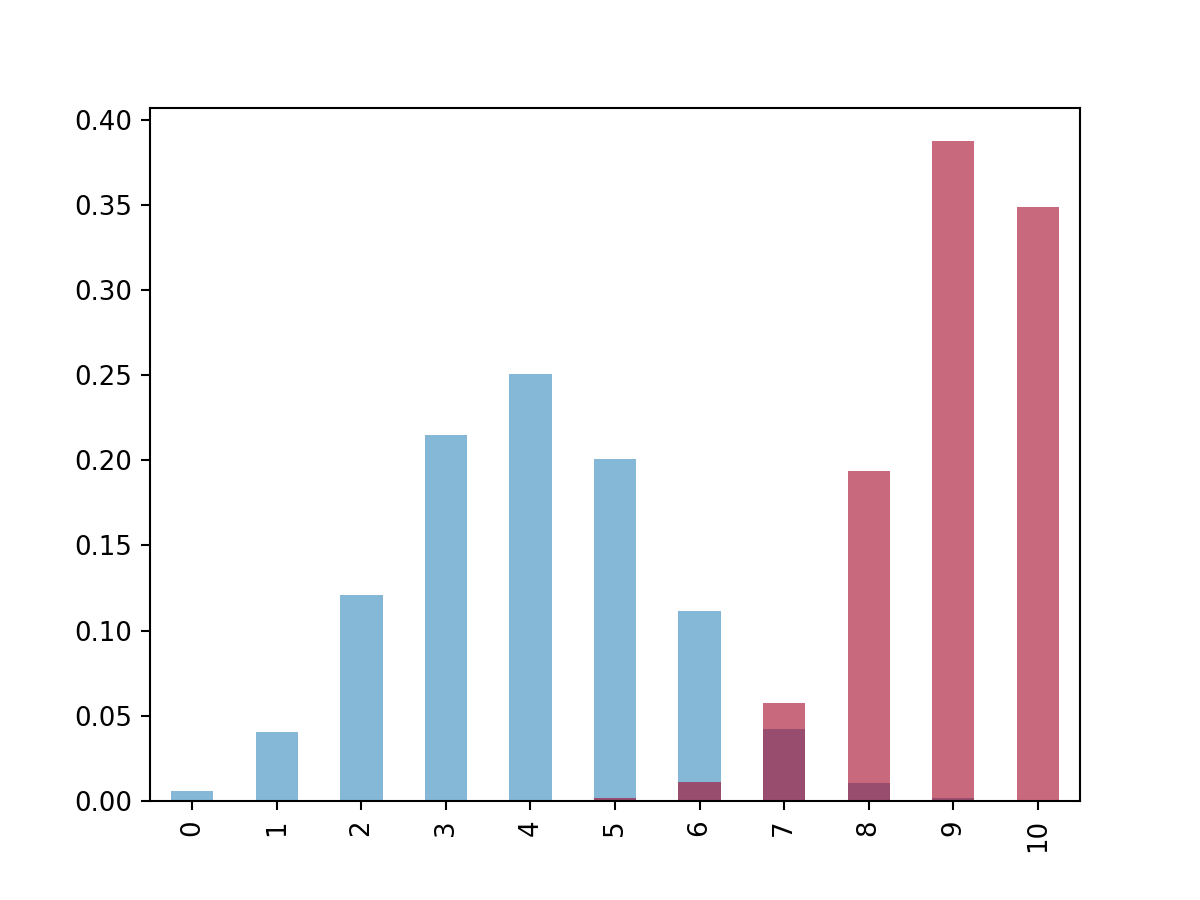

In [5]:
n1=10;p1=.4
# x取值为[0,1..10]~B(10,0.4), 这些值对应的概率质量值
binomial_1 = stats.binom.pmf(np.arange(n1+1),n1,p1)
n2=10;p2=.9
binomial_2 = stats.binom.pmf(np.arange(n2+1),n2,p2)
pd.Series(binomial_1).plot.bar(color='#348ABD',alpha=0.6,label='1qqqqq')
pd.Series(binomial_2).plot.bar(color='#A60628',alpha=0.6)

#### 五. 学生作弊问题建模
1. 问题描述 :  
 1. 目标 : 我们要采访确定一场考试中, 作弊人数的比率p.  
 2. 符号 : N表示参加考试的学生人数, 每个考生考试结束后都会参加采访. 收到"是的, 我作弊了"的人数为X. 
2. 采访策略 :  
 如果直接问学生是否作弊, 恐怕没有人会承认自己刚才作弊了.一次采用一种'隐私算法'  受采访的学生, 先抛一枚硬币:  
  1. 若正面朝上,则必须诚实回答是否作弊了.
  2. 若反面朝上, 则可再抛第二枚硬币.   
    1. 第二枚硬币如果正面朝上, 回答'我作弊了';
    2. 如果反面朝上, 回答'我没作弊'  
    
 因此, 当学生回答我作弊了, 就无法知道是第一次抛硬币说出的真话,还是第二次抛硬币的随即结果. 保护了学生的隐私

3. 统计思路 : 给定N, 对作弊比率p做后验分布  
  1. 简单假设P服从[0,1]的均匀分布
  2. 模拟真是作弊数据 : 生成100个学生的真实情况, 为100个学生设置'伯努利随机变量' (1: 作弊,0: 没作弊)
  3. 模拟采访过程生成的数据:  
    1. 第一次扔硬币 : P(正面)=0.5的伯努利随机变量, 抽样100次  
    2. 第二次扔硬币 : 同样为P(正面)=0.5的伯努利随机变量, 抽样100次  
  4. '是的'回答的实现方式 : 第一次投币为正面&确实作弊了 + 第一次正面&第二次反面 
  第四步,模拟了回答'作弊了'的结果
  5. 加入证据 :   
   采访之后, 共收到35个'是的'答案

In [7]:
# 受采访人数100人
N=100
# 1. 先验: 作弊概率服从[0,1]的均匀分布
p = pm.Uniform('freq_cheating',0,1)
# 2. 在先验作弊率的情况下100个学生真实情况的伯努利
true_answers = pm.Bernoulli('truths',p,size=N)
# 3. 模拟采访数据
first_coin_flips = pm.Bernoulli('first_coin_flips',0.5,size=N)
# print 'first_coin_flips: ',first_coin_flips.value
second_coin_flips = pm.Bernoulli('second_coin_flips',0.5,size=N)
# print 'second_coin_flips: ',second_coin_flips.value
# 4. '是的'实现方式
@pm.deterministic
def observed_proportion(t_a=true_answers,fc=first_coin_flips,sc=second_coin_flips):  
    observed = fc*t_a + (1-fc)*sc
    return observed.sum()*1./N
print (observed_proportion.value)

0.32


In [11]:
# 受采访的结果中, 得到35个'是'回答
X = 35
observations = pm.Binomial('obs',N,observed_proportion,value=X,observed=True)
# 所有变量加入模型中, 并进行MCMC抽样
model = pm.Model([p,true_answers,first_coin_flips,second_coin_flips,observed_proportion,observations])
mcmc = pm.MCMC(model)
# mcmc.sample(40000,15000)

/devkit/anaconda3/lib/python3.6/site-packages/pymc/MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)
